In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
# === LOAD MNIST ===
DATA_FOLDER = './data/'
BATCH_SIZE = 128
print("Load MNIST... ", end="")
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=DATA_FOLDER, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_FOLDER, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
ALL_TRAIN_LEN = len(train_dataset)
ALL_TEST_LEN = len(test_dataset)
all_train_loader = DataLoader(train_dataset, batch_size=ALL_TRAIN_LEN, shuffle=True)
all_test_loader = DataLoader(test_dataset, batch_size=ALL_TEST_LEN, shuffle=False)
print("done.")

# add load CIFAR

Load MNIST... 

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]

done.


In [ ]:
# @title Utils functions and initialization scripts
def plot_cum_variance_explained(pca, n_pcs):
    plt.figure(figsize=(3, 2))
    plt.title("Cumulative explained variance")
    plt.plot(range(1, n_pcs + 1), np.cumsum(pca.explained_variance_ratio_), "o-")
    plt.xlabel("PCs")
    plt.ylabel("% explained variance")
    plt.show()


def plot_image_samples(images, n_imgs, fig_title=""):
    """Plot some samples
    Args:
        n_imgs: (int) number of images to be plotted.
    """
    plt.figure(figsize=(10, 3))
    plt.title(fig_title)
    plt.box(False)
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    for img_i in range(n_imgs):
        plt.subplot(int(np.ceil(30 / 7)), 7, 1 + img_i)
        plt.imshow(images[img_i], cmap='gray_r')
        plt.tick_params(left=False, right=False, labelleft=False,
                        labelbottom=False, bottom=False)


def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss", marker='o')
  plt.plot(test_losses, label="Test Loss", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss per Epoch")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy", marker='o')
  plt.plot(test_accuracies, label="Test Accuracy", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy per Epoch")
  plt.legend()
  plt.tight_layout()
  plt.show()


In [ ]:
# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## PCA on MNIST

In [ ]:
all_train_iter, all_test_iter = iter(all_train_loader), iter(all_test_loader)
all_train_images, all_train_labels = next(all_train_iter)
all_test_images, all_test_labels = next(all_test_iter)

Creating low-dim MNIST datasets...10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,410,

/tmp/ipython-input-3-3557687517.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 3))


430,450,470,490,done


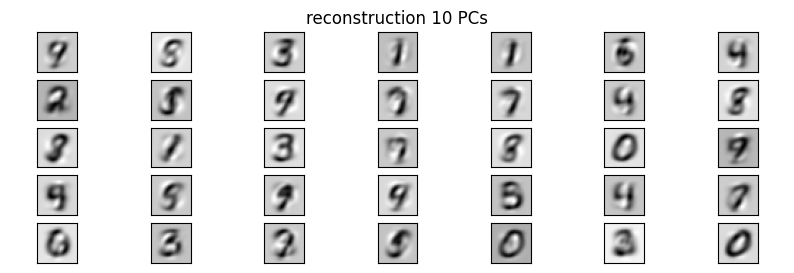

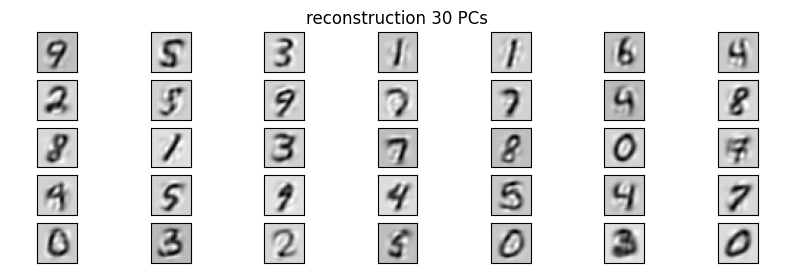

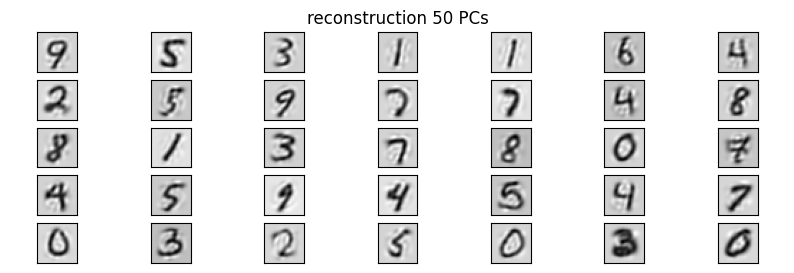

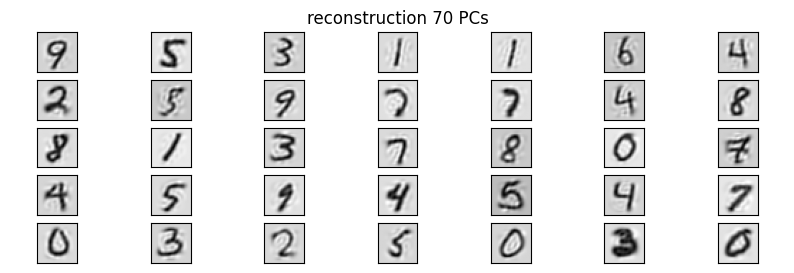

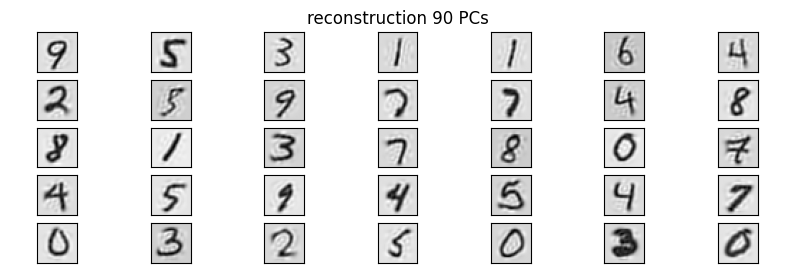

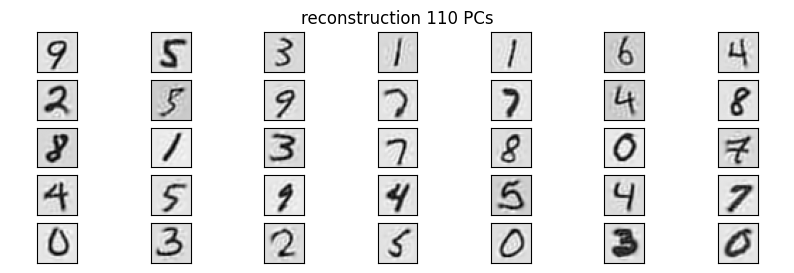

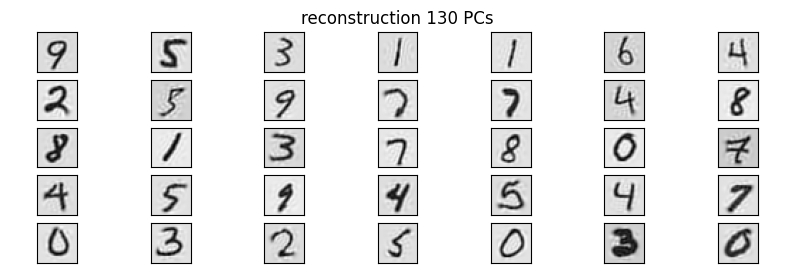

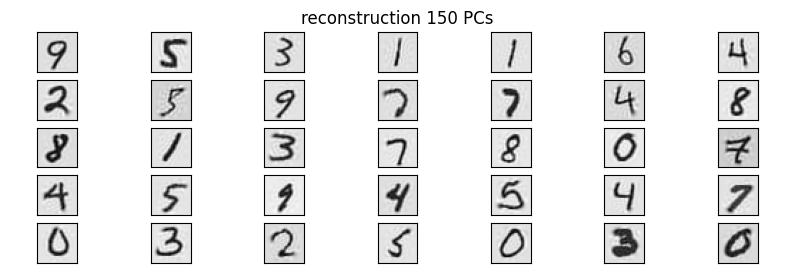

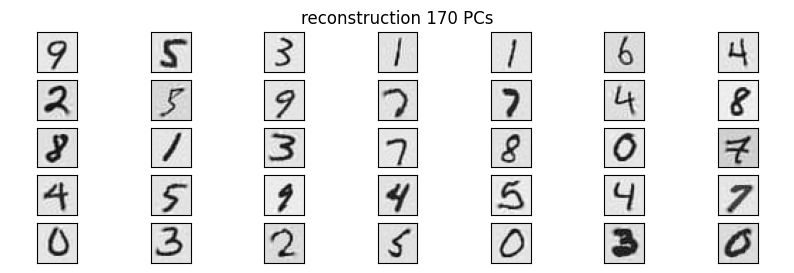

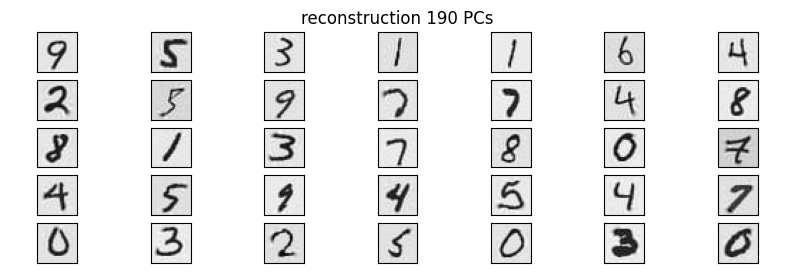

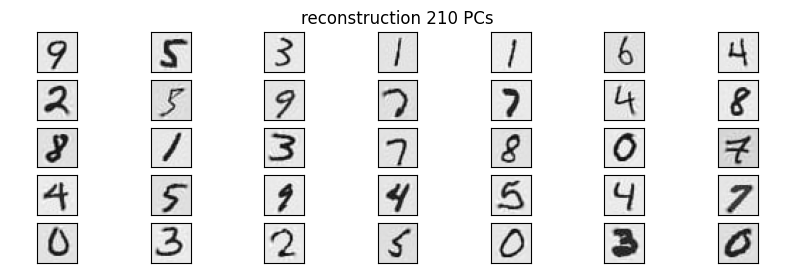

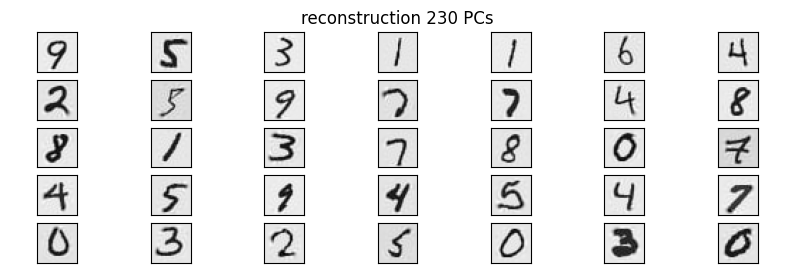

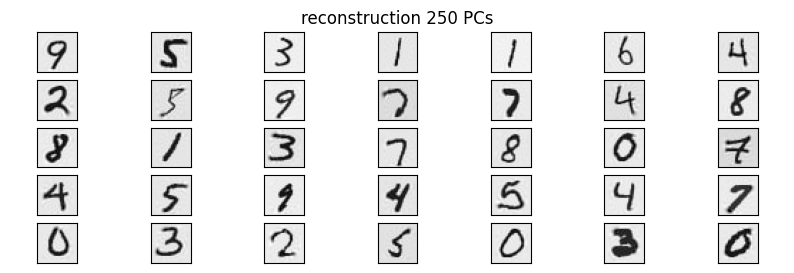

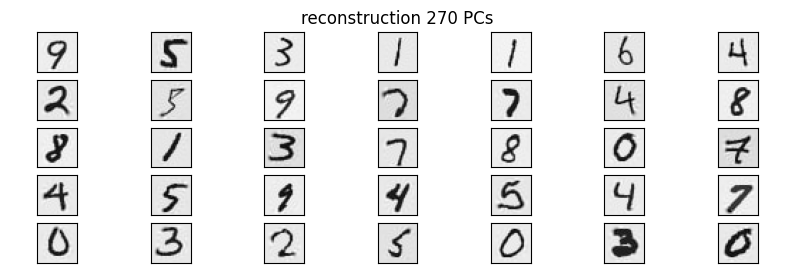

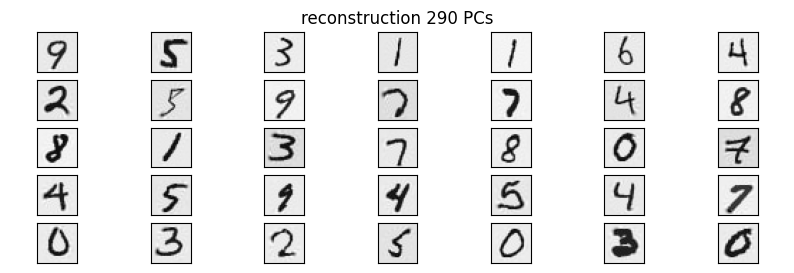

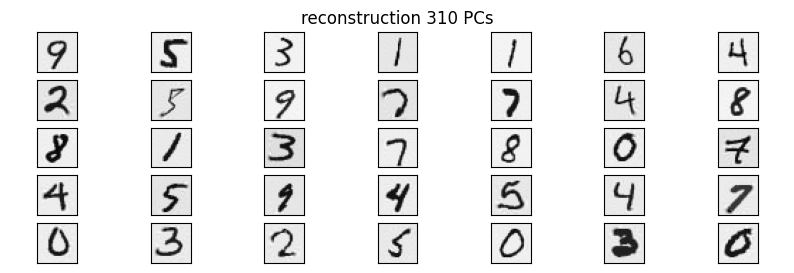

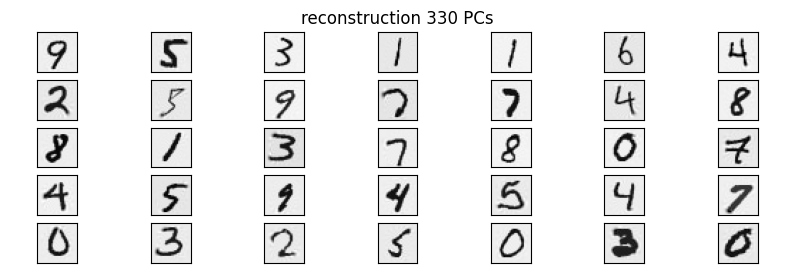

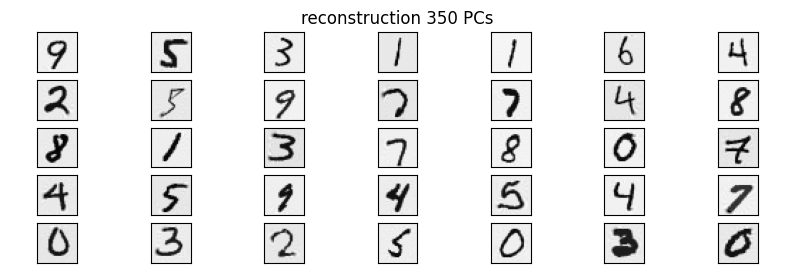

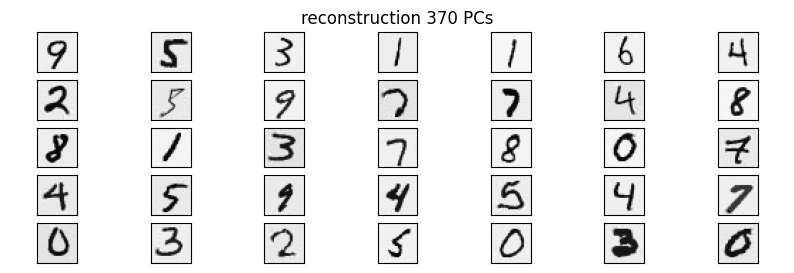

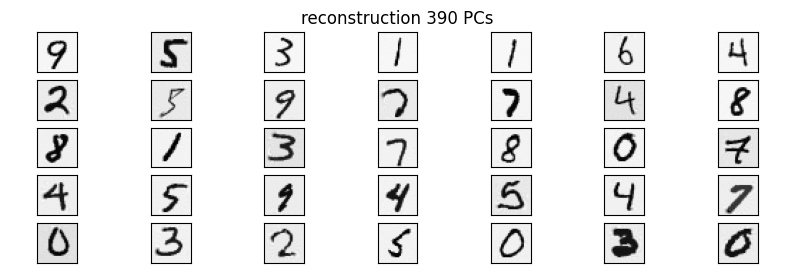

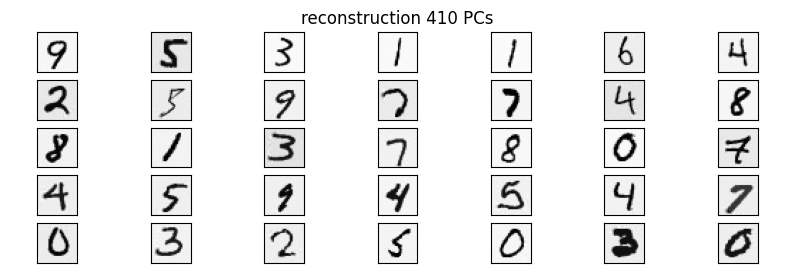

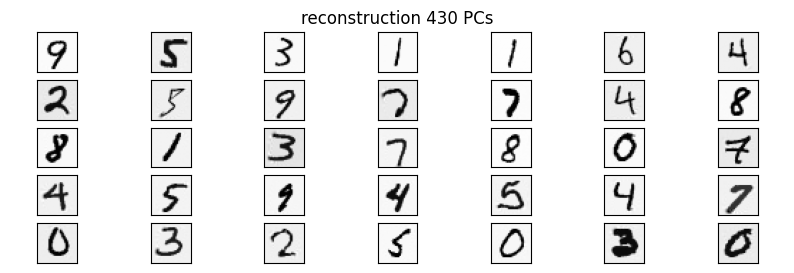

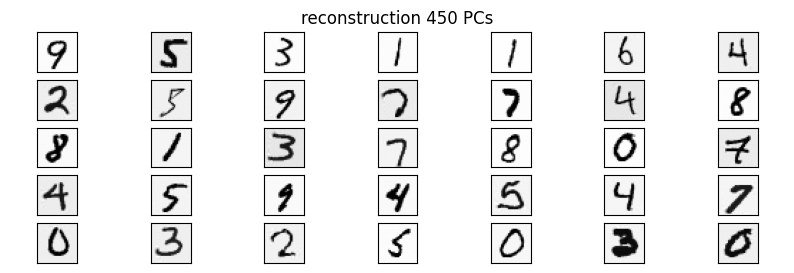

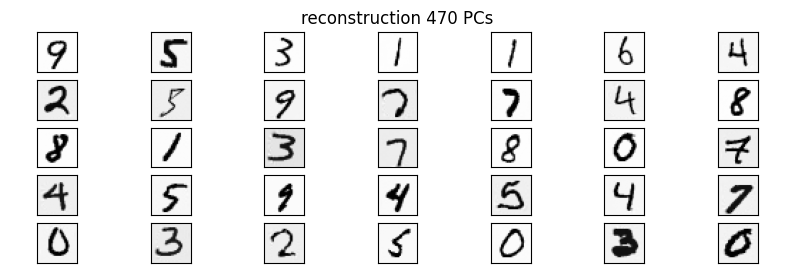

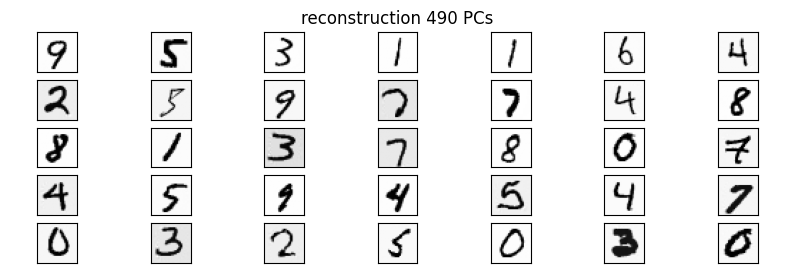

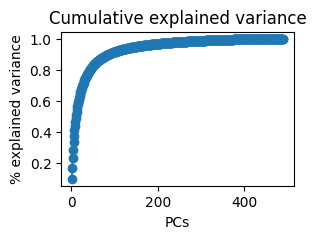

In [ ]:
# Prepare flattened images
all_train_images_flat = all_train_images.squeeze().reshape(ALL_TRAIN_LEN, -1)
all_test_images_flat = all_test_images.squeeze().reshape(ALL_TEST_LEN, -1)

# Dimension settings
# DST_DIMS = [10, 35, 500]
DST_DIMS = range(10, 500, 20)
# DST_DIMS = [2, 4, 6, 8] + list(range(10, 50, 5)) + list(range(50, 100, 10)) + list(range(100, 200, 20)) + list(range(200,650, 25))

# Initialize dictionaries
dsts_train, dsts_test = dict.fromkeys(DST_DIMS), dict.fromkeys(DST_DIMS)

print("Creating low-dim MNIST datasets...", end="")
for n_pcs in DST_DIMS:
    print(n_pcs, end=",")
    # Fit PCA on train images
    pca = PCA(n_components=n_pcs)
    pca.fit(all_train_images_flat)

    # Apply to train set
    proj_X_train = pca.transform(all_train_images_flat)
    recnst_X_train = pca.inverse_transform(proj_X_train)

    trainset = TensorDataset(torch.Tensor(recnst_X_train), all_train_labels)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    dsts_train[n_pcs] = trainloader

    # plot_image_samples(recnst_X_train.reshape(len(train_dataset), 28, 28), 35, fig_title=f"reconstruction {n_pcs} PCs")

    # Apply to test set (fit is on train, as best practice)
    proj_X_test = pca.transform(all_test_images_flat)
    recnst_X_test = pca.inverse_transform(proj_X_test)

    testset = TensorDataset(torch.Tensor(recnst_X_test), all_test_labels)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    #Save the testloader and trainloader for CIFAR and MNIST
    dsts_test[n_pcs] = testloader
print("done")

plot_cum_variance_explained(pca, n_pcs)
plt.show()

## Define classifier for the reconstructed images

In [ ]:
# === CLASSIFIER ===
class Classifier(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Classify PCA-reduced datasets

ReconClassifier Epoch 1, Loss: 159.20, Train Acc: 90.79%
### DIM=10 ###
Accuracy on Reconstructed Images (Separate Classifier): 83.23%
### DIM=30 ###
Accuracy on Reconstructed Images (Separate Classifier): 93.12%
### DIM=50 ###
Accuracy on Reconstructed Images (Separate Classifier): 94.41%
### DIM=70 ###
Accuracy on Reconstructed Images (Separate Classifier): 94.79%
### DIM=90 ###
Accuracy on Reconstructed Images (Separate Classifier): 94.82%
### DIM=110 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.03%
### DIM=130 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.13%
### DIM=150 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.05%
### DIM=170 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.07%
### DIM=190 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.12%
### DIM=210 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.12%
### DIM=230 ###
Accuracy on Reconstructed Images (Separate Classifier): 95.16%


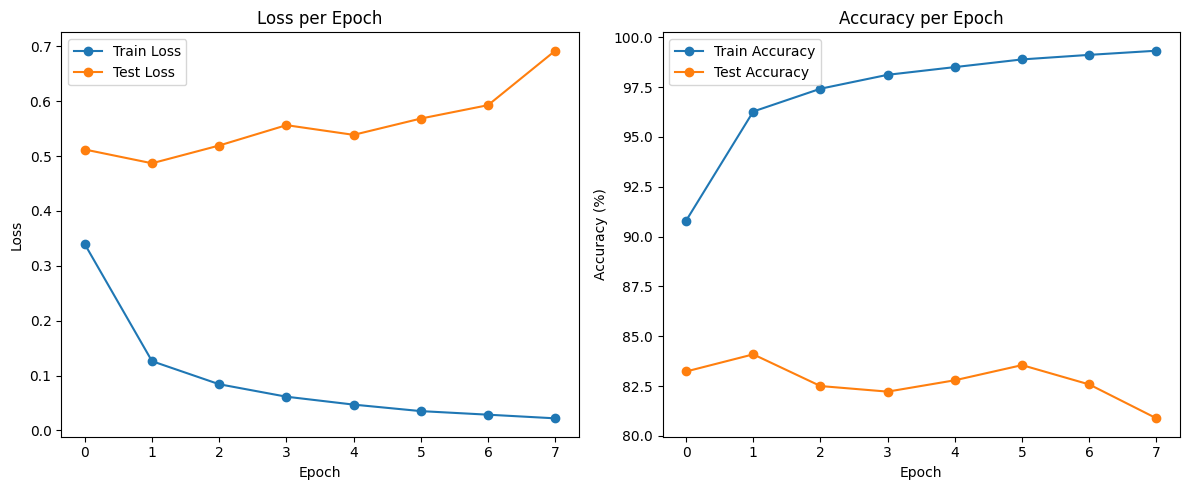

### DIM=30 ###
Accuracy on Reconstructed Images (Separate Classifier): 96.10%


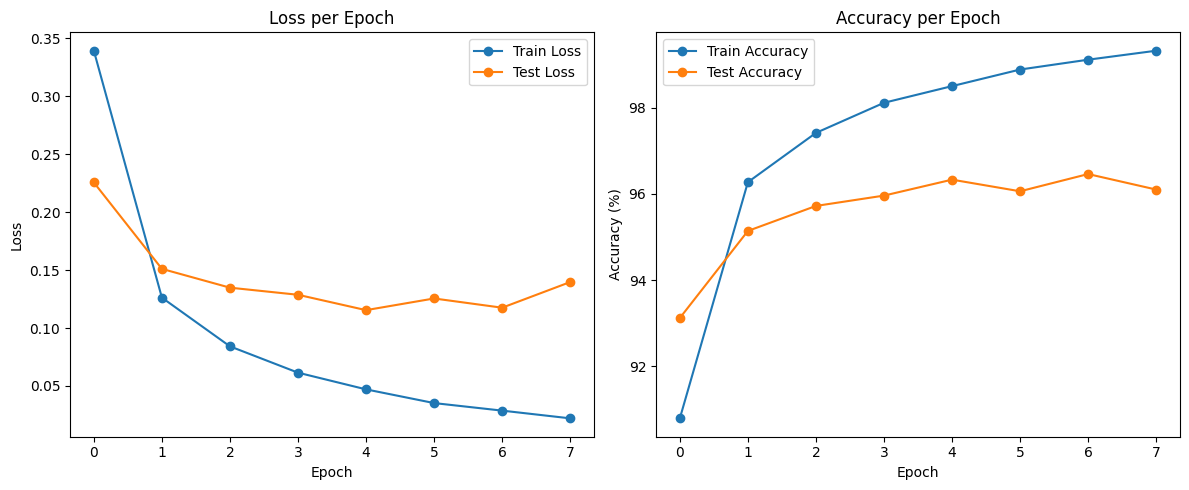

### DIM=50 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.14%


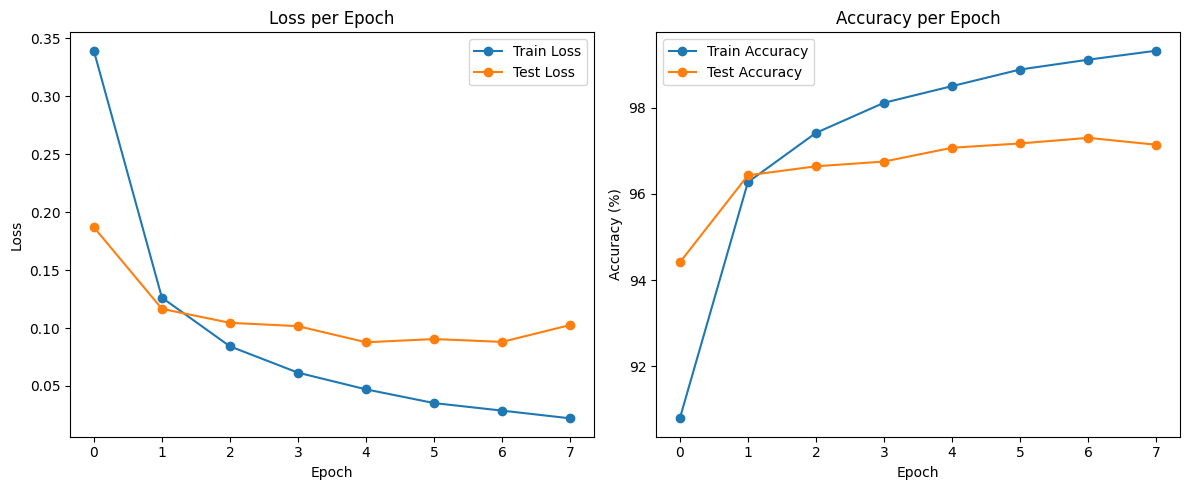

### DIM=70 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.38%


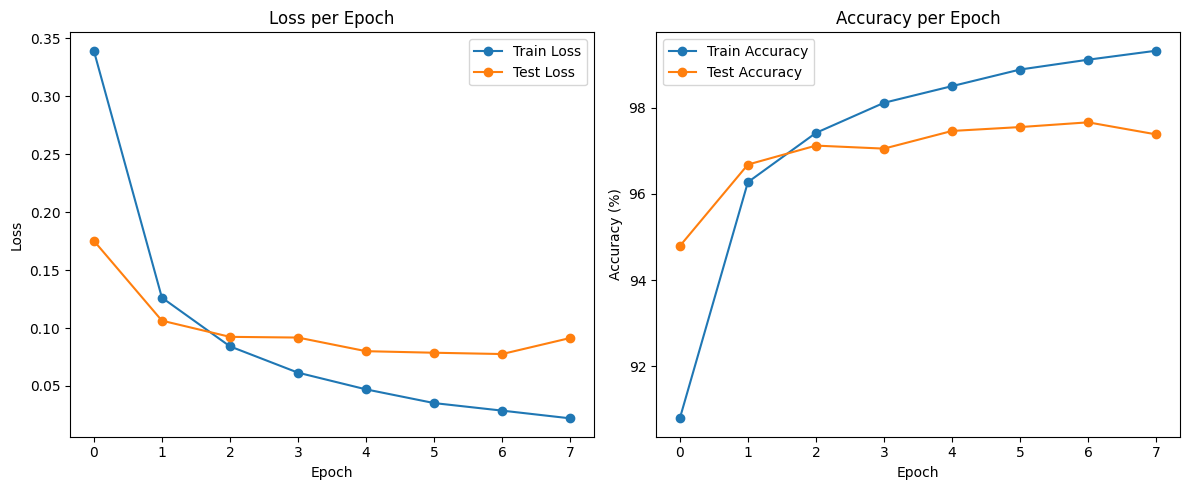

### DIM=90 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.59%


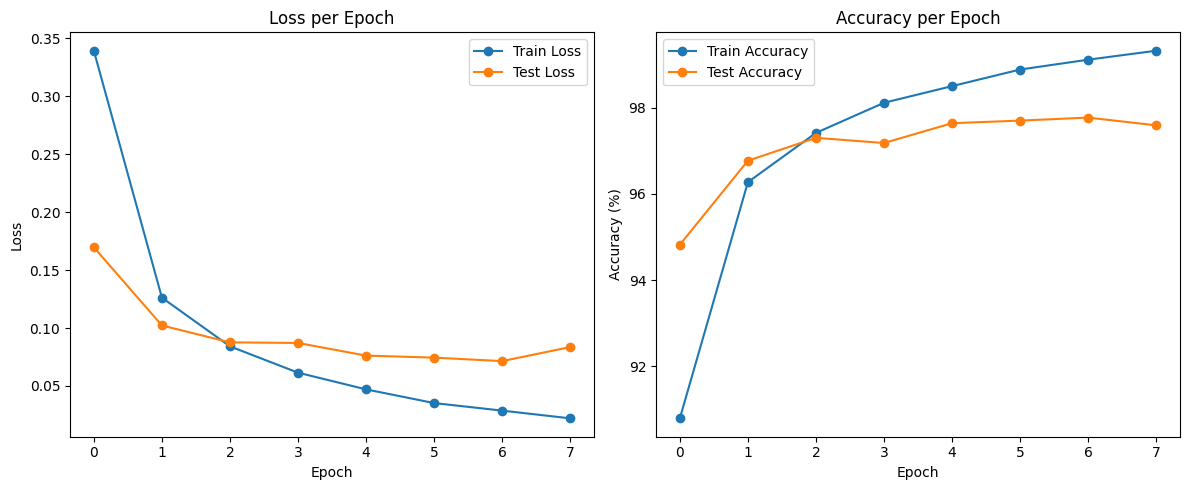

### DIM=110 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.77%


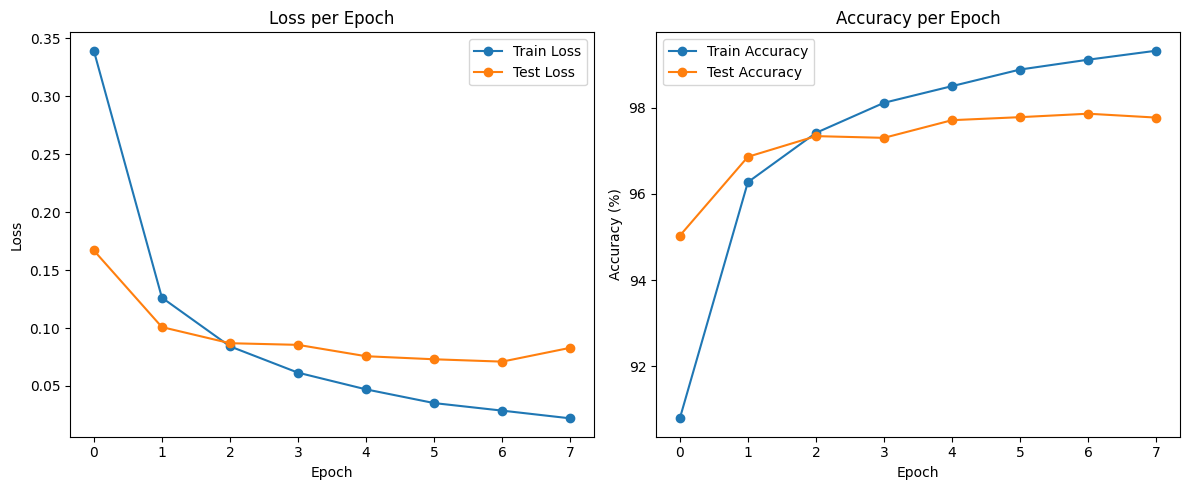

### DIM=130 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.71%


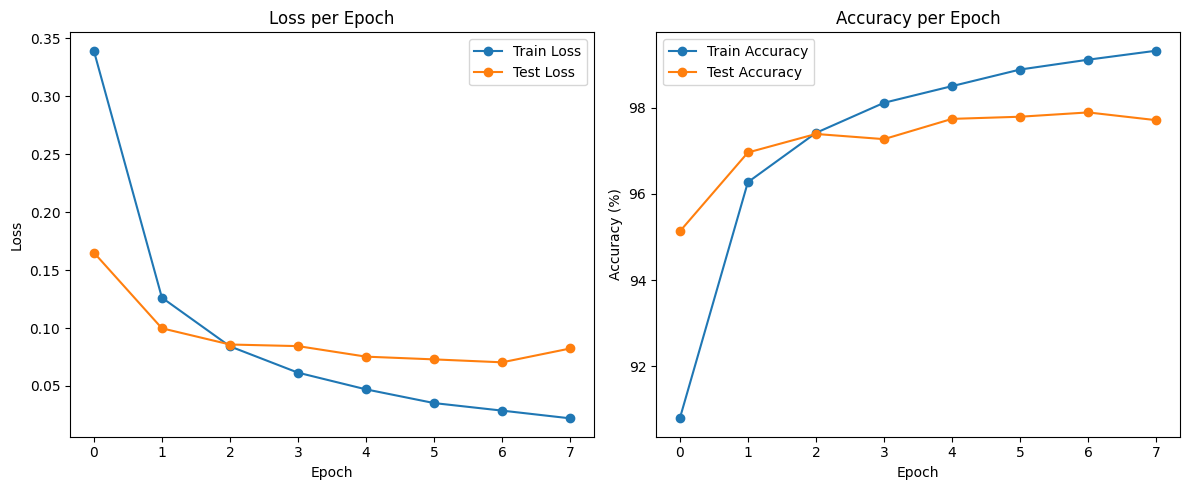

### DIM=150 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.76%


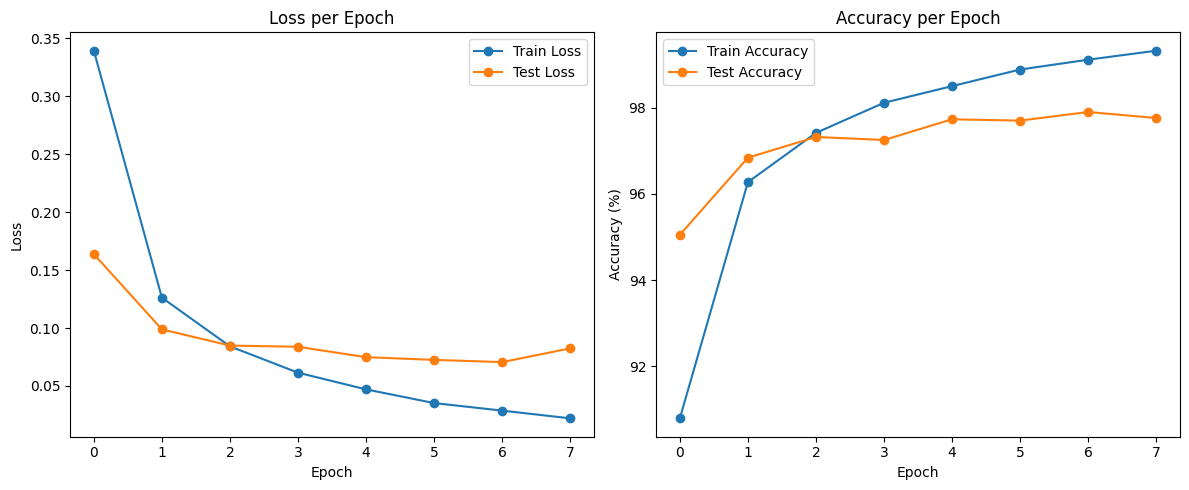

### DIM=170 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.69%


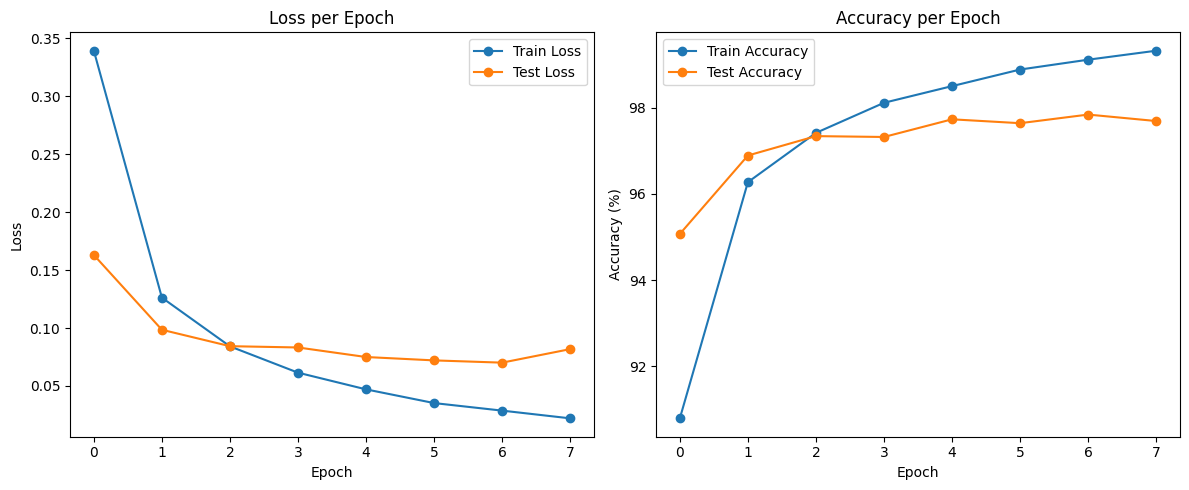

### DIM=190 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.70%


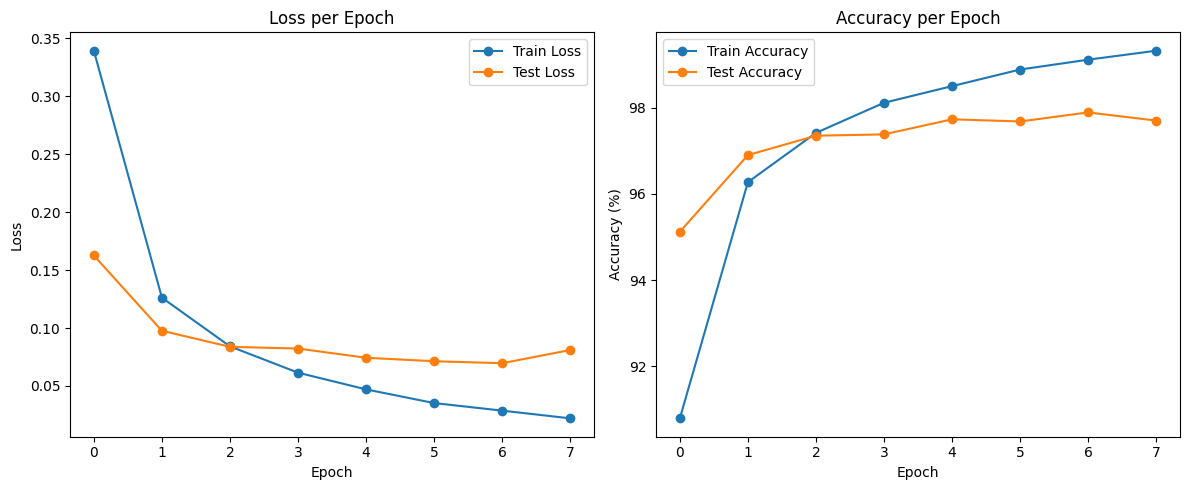

### DIM=210 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.68%


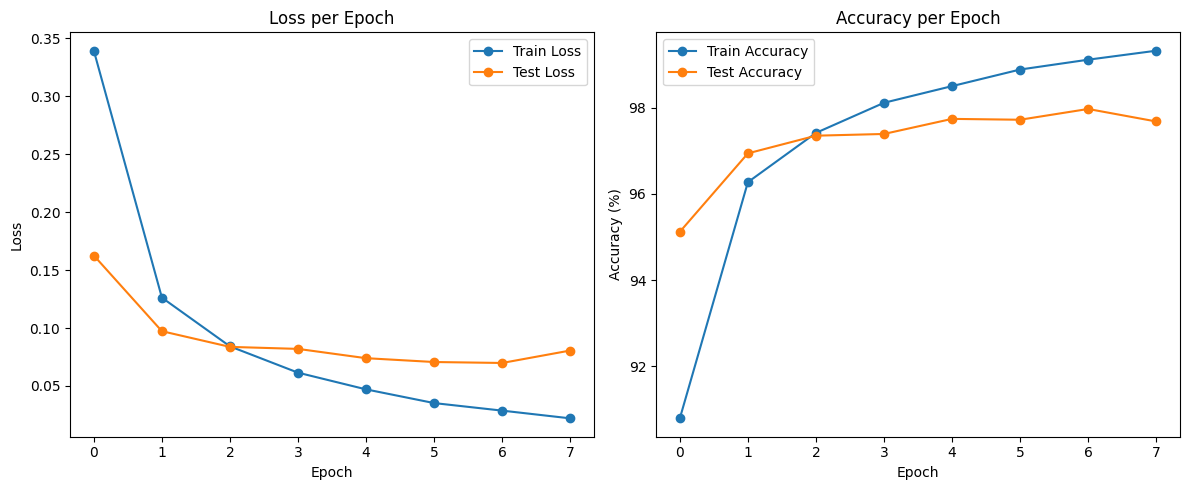

### DIM=230 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.72%


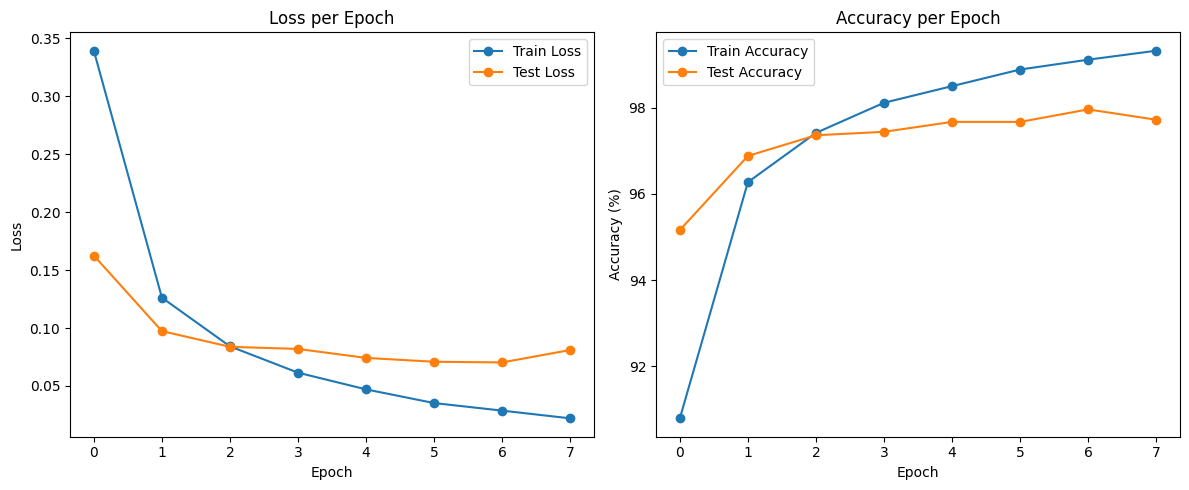

### DIM=250 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.72%


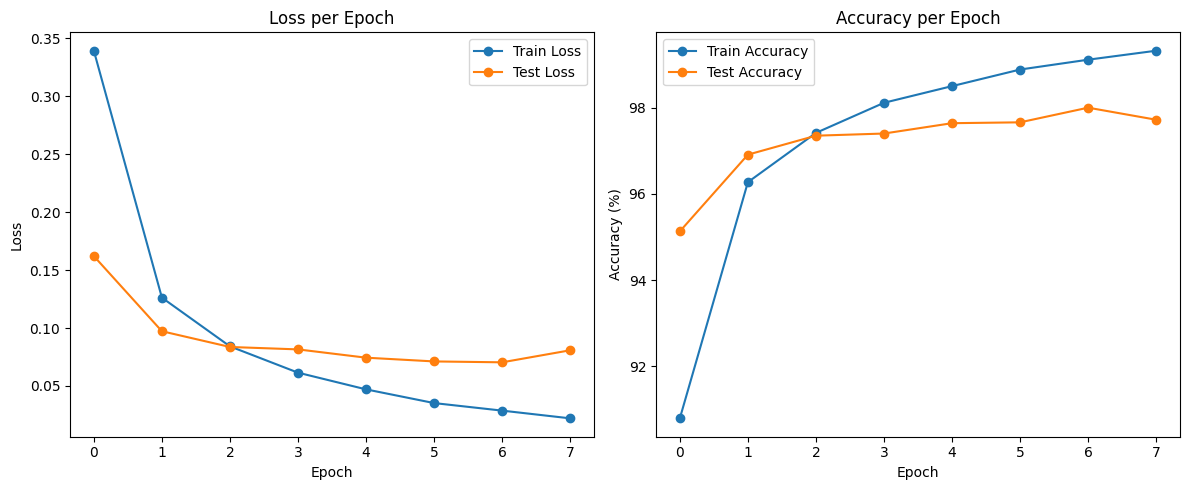

### DIM=270 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.72%


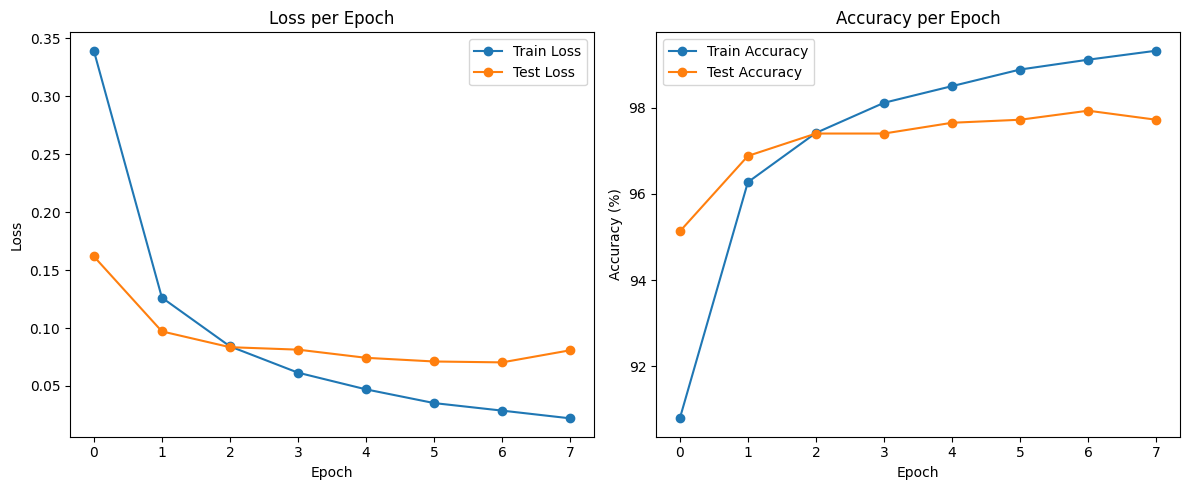

### DIM=290 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.72%


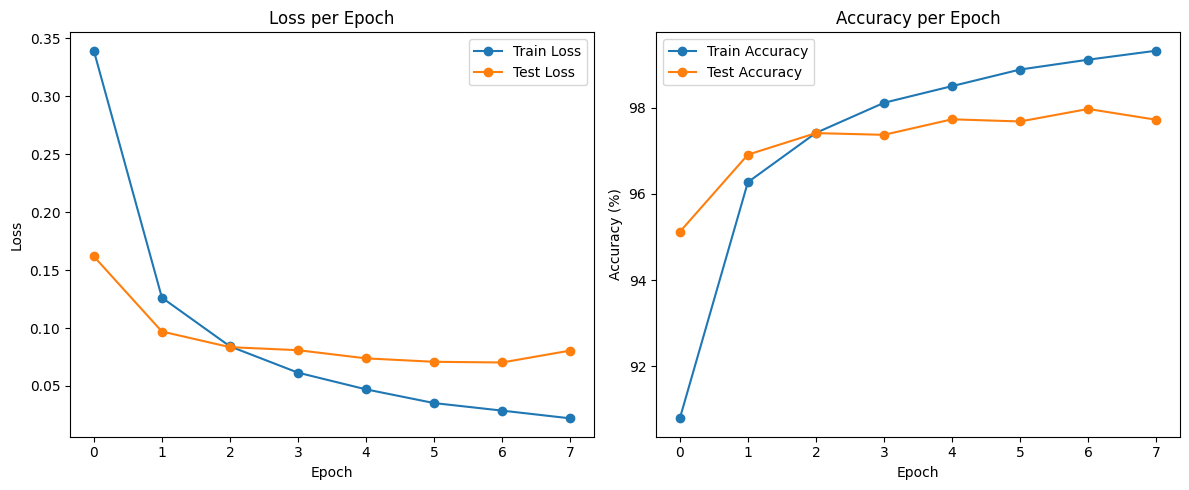

### DIM=310 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.71%


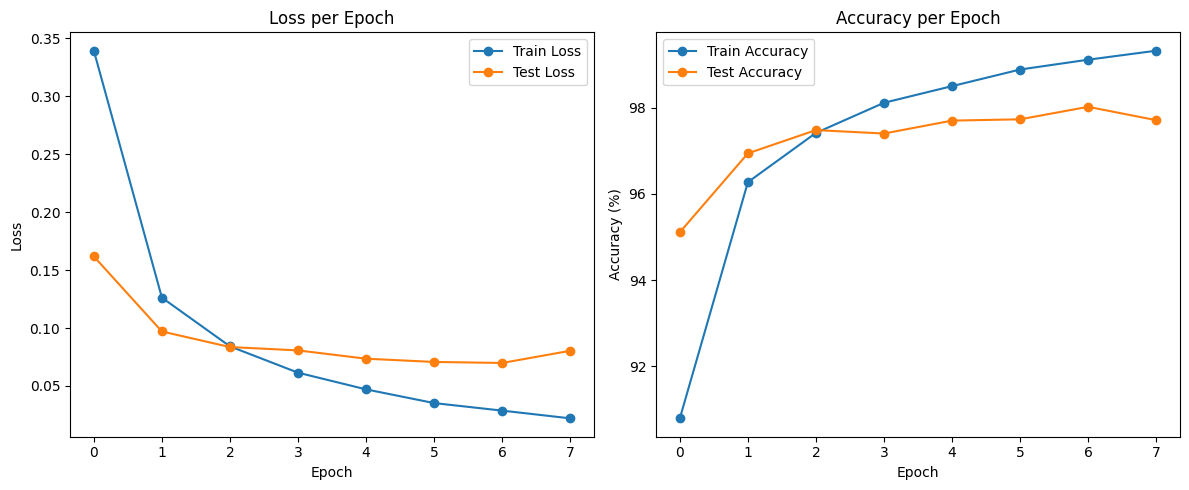

### DIM=330 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.73%


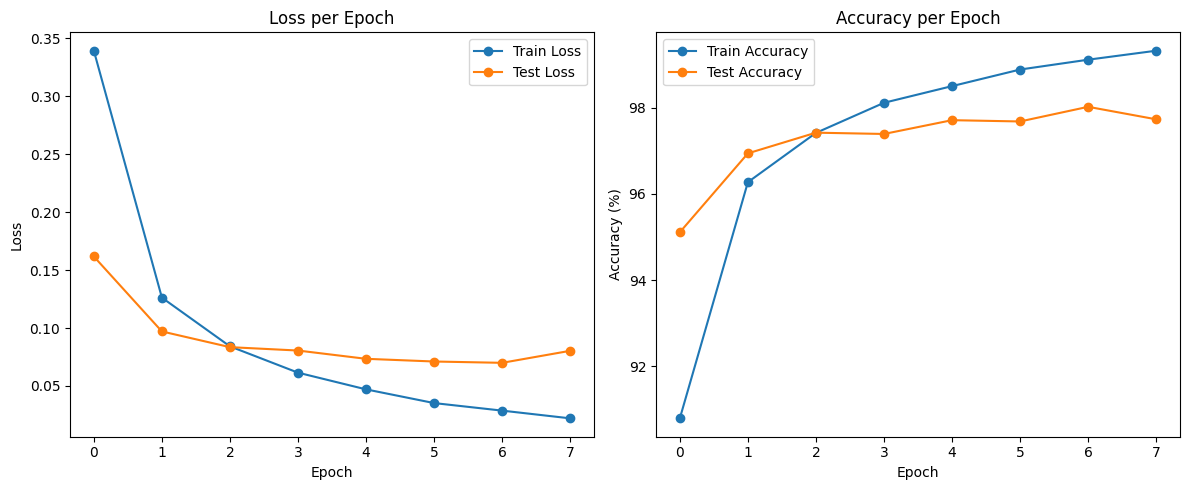

### DIM=350 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.71%


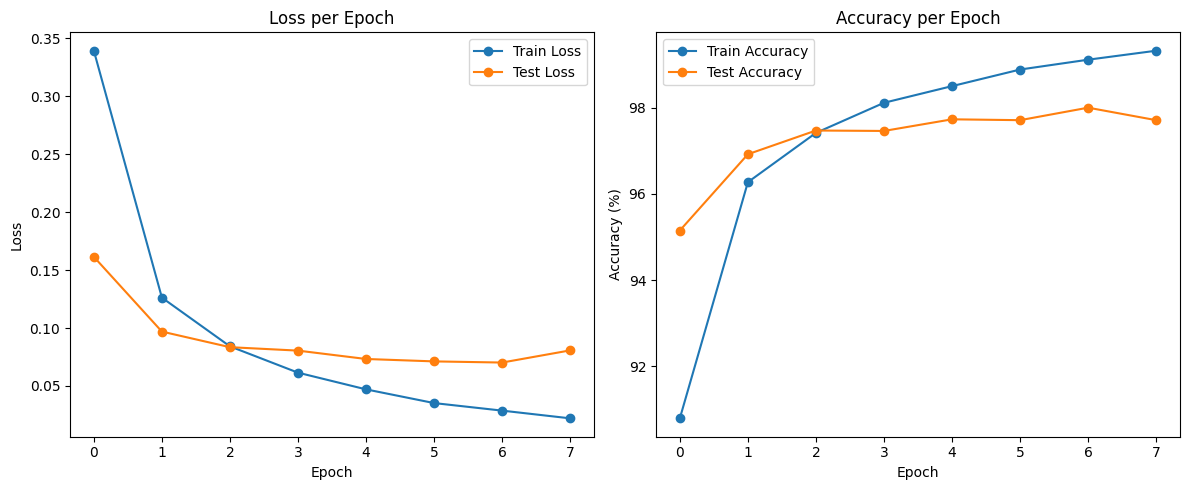

### DIM=370 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.71%


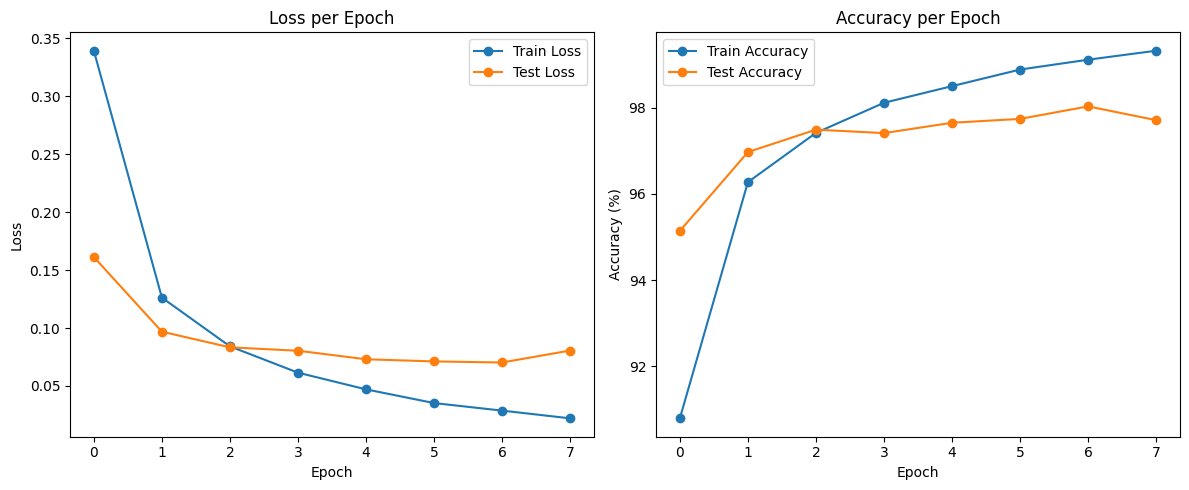

### DIM=390 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.66%


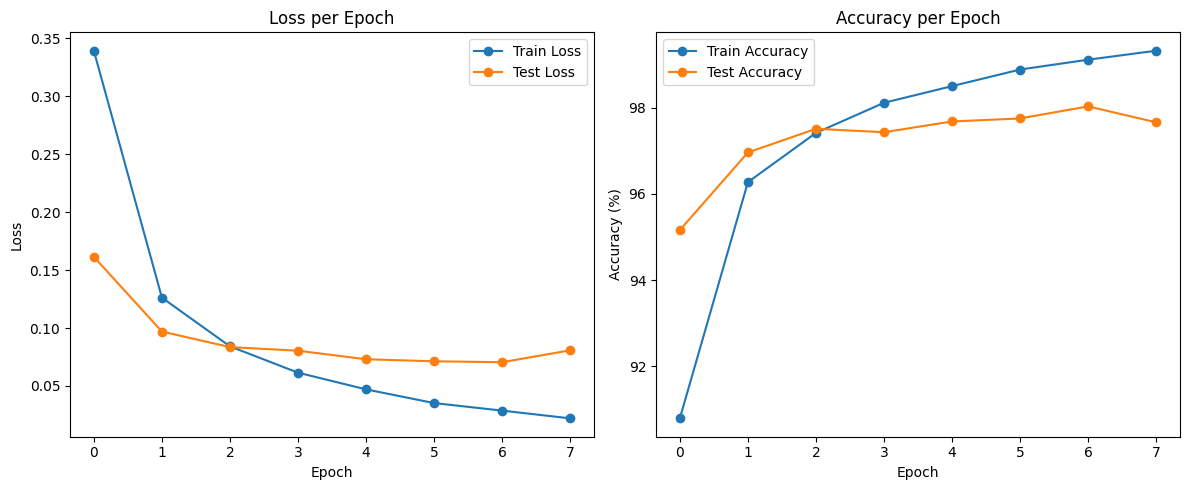

### DIM=410 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.66%


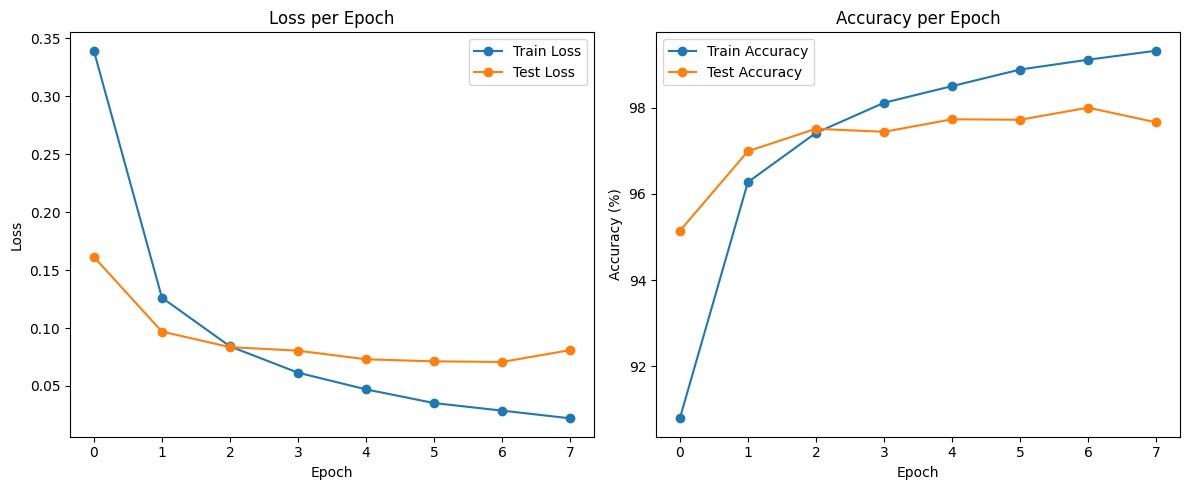

### DIM=430 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.68%


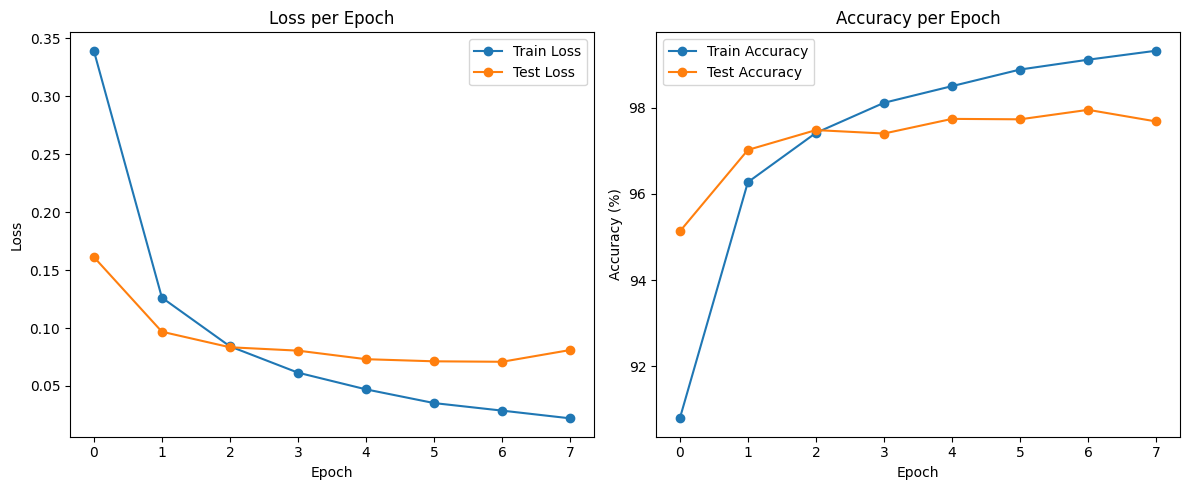

### DIM=450 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.71%


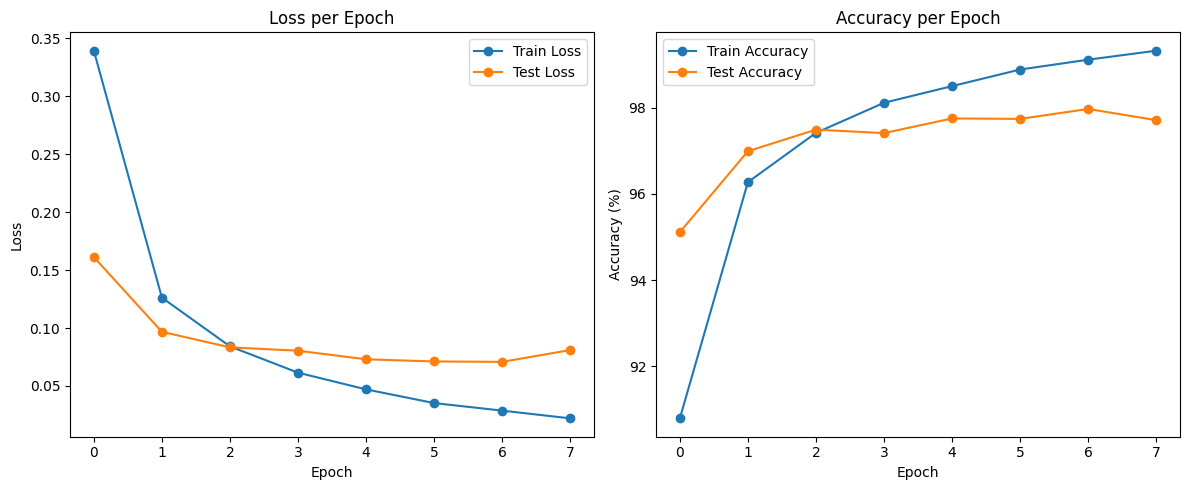

### DIM=470 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.73%


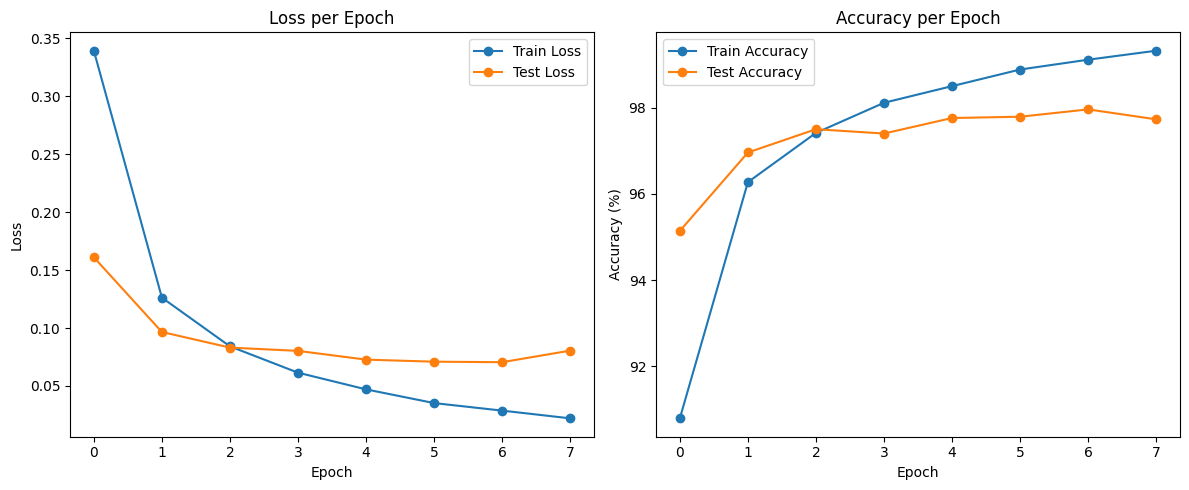

### DIM=490 ###
Accuracy on Reconstructed Images (Separate Classifier): 97.75%


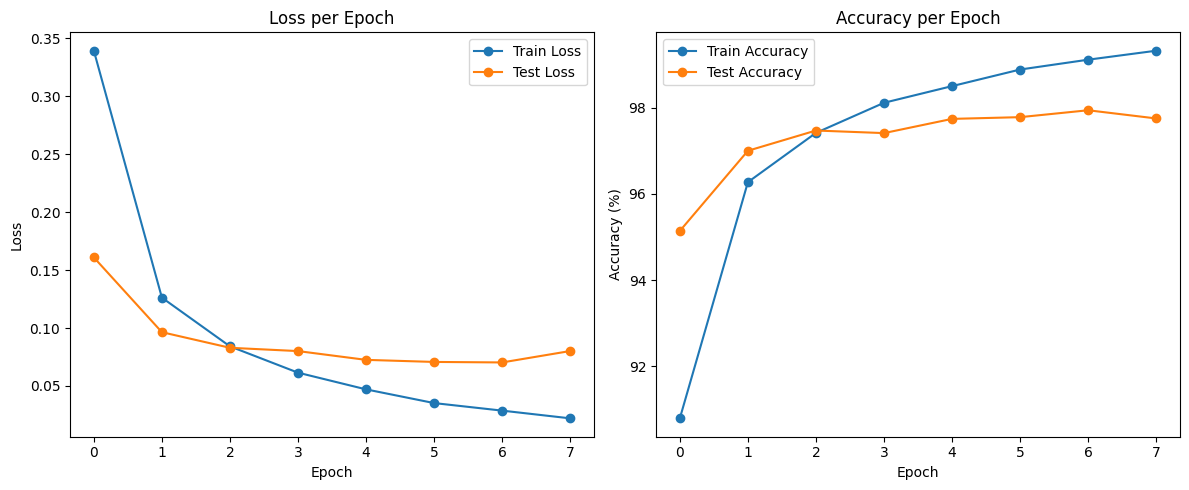

In [ ]:
recon_clf = Classifier().to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

# === TRAIN RECONSTRUCTION CLASSIFIER ON ORIGINAL IMAGES ===
clf_epochs = 8
clf_train_losses, clf_train_accuracies = [], []
clf_test_losses, clf_test_accuracies = {dim: [] for dim in DST_DIMS}, {dim: [] for dim in DST_DIMS}

for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    clf_train_losses.append(clf_loss / len(train_loader))
    clf_train_accuracies.append(100. * correct / total)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

    for dim in DST_DIMS:
        print(f"### DIM={dim} ###")

        # === EVALUATE CLASSIFIER ON RECONSTRUCTED IMAGES ===
        recon_clf.eval()
        test_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in dsts_test[dim]:
                data = data.view(-1, 784).to(device)
                target = target.to(device)
                logits = recon_clf(data)
                loss = F.cross_entropy(logits, target)
                test_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)  # add batch_size
        recon_acc = 100. * correct / total
        clf_test_losses[dim].append(test_loss / len(dsts_test[dim]))  # divide by the number of batches
        clf_test_accuracies[dim].append(100. * correct / total)
        print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

        if epoch==clf_epochs-1:
            # === PLOT TRAINING CURVE FOR CLASSIFIER - LOSSES AND ACCURACIES ===
            plot_training_curves(clf_train_losses, clf_test_losses[dim], clf_train_accuracies, clf_test_accuracies[dim])

Text(0, 0.5, 'Accuracy %')

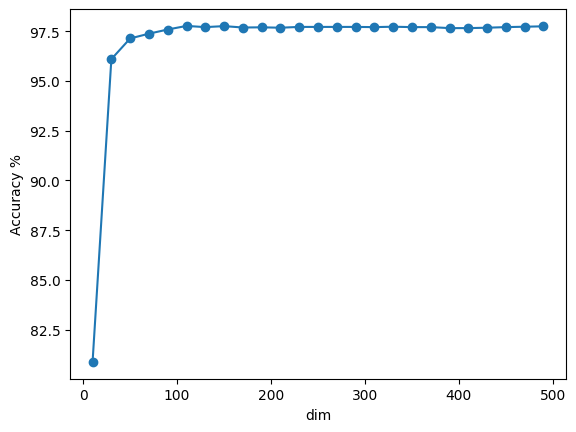

In [ ]:
plt.plot(DST_DIMS, [clf_test_accuracies[dim][-1] for dim in DST_DIMS], "o-")
plt.xlabel("dim")
plt.ylabel("Accuracy %")

## Define VAE

In [ ]:
# === VAE WITH CLASSIFIER ===
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50, num_classes=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits

# === VAE LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return BCE + KLD + alpha * CE

## Init models and train

Epoch 1/12, Train Loss: 170.9926, Test Loss: 135.1418, Train Acc: 55.62%, Test Acc: 76.30%
Epoch 2/12, Train Loss: 127.6869, Test Loss: 120.4903, Train Acc: 79.16%, Test Acc: 81.90%
Epoch 3/12, Train Loss: 118.3494, Test Loss: 114.8746, Train Acc: 82.18%, Test Acc: 84.38%
Epoch 4/12, Train Loss: 113.9985, Test Loss: 111.7590, Train Acc: 83.66%, Test Acc: 85.44%
Epoch 5/12, Train Loss: 111.4781, Test Loss: 109.8330, Train Acc: 84.89%, Test Acc: 85.79%
Epoch 6/12, Train Loss: 109.9519, Test Loss: 108.8749, Train Acc: 85.40%, Test Acc: 85.72%
Epoch 7/12, Train Loss: 108.8805, Test Loss: 107.8323, Train Acc: 85.93%, Test Acc: 86.27%
Epoch 8/12, Train Loss: 108.1096, Test Loss: 107.2293, Train Acc: 86.06%, Test Acc: 87.24%
Epoch 9/12, Train Loss: 107.5201, Test Loss: 106.8171, Train Acc: 86.44%, Test Acc: 87.47%
Epoch 10/12, Train Loss: 107.0061, Test Loss: 106.3700, Train Acc: 86.78%, Test Acc: 87.57%
Epoch 11/12, Train Loss: 106.6965, Test Loss: 106.3513, Train Acc: 86.92%, Test Acc: 87.5

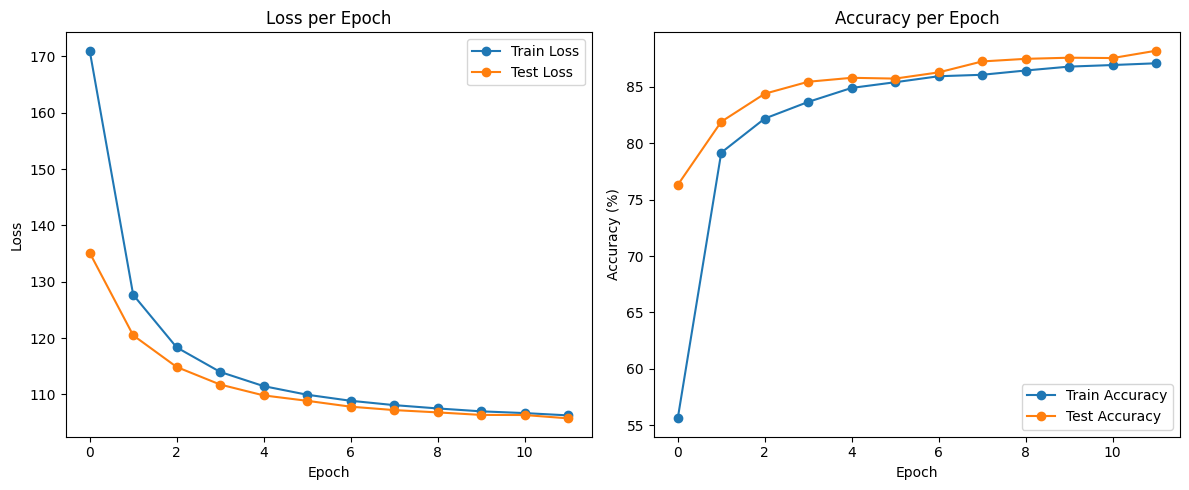

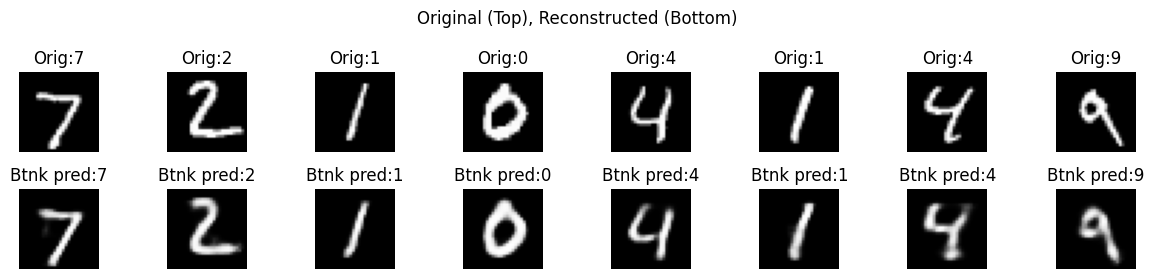

ReconClassifier Epoch 1, Loss: 166.18, Train Acc: 90.19%
Accuracy on Reconstructed Images (Separate Classifier): 93.65%
ReconClassifier Epoch 2, Loss: 65.04, Train Acc: 95.86%
Accuracy on Reconstructed Images (Separate Classifier): 94.97%
ReconClassifier Epoch 3, Loss: 42.09, Train Acc: 97.24%
Accuracy on Reconstructed Images (Separate Classifier): 95.35%
ReconClassifier Epoch 4, Loss: 30.62, Train Acc: 97.98%
Accuracy on Reconstructed Images (Separate Classifier): 95.69%
ReconClassifier Epoch 5, Loss: 23.35, Train Acc: 98.41%
Accuracy on Reconstructed Images (Separate Classifier): 95.91%
ReconClassifier Epoch 6, Loss: 18.19, Train Acc: 98.80%
Accuracy on Reconstructed Images (Separate Classifier): 96.09%
ReconClassifier Epoch 7, Loss: 14.13, Train Acc: 99.06%
Accuracy on Reconstructed Images (Separate Classifier): 96.03%
ReconClassifier Epoch 8, Loss: 11.19, Train Acc: 99.25%
Accuracy on Reconstructed Images (Separate Classifier): 95.91%
ReconClassifier Epoch 9, Loss: 8.60, Train Acc:

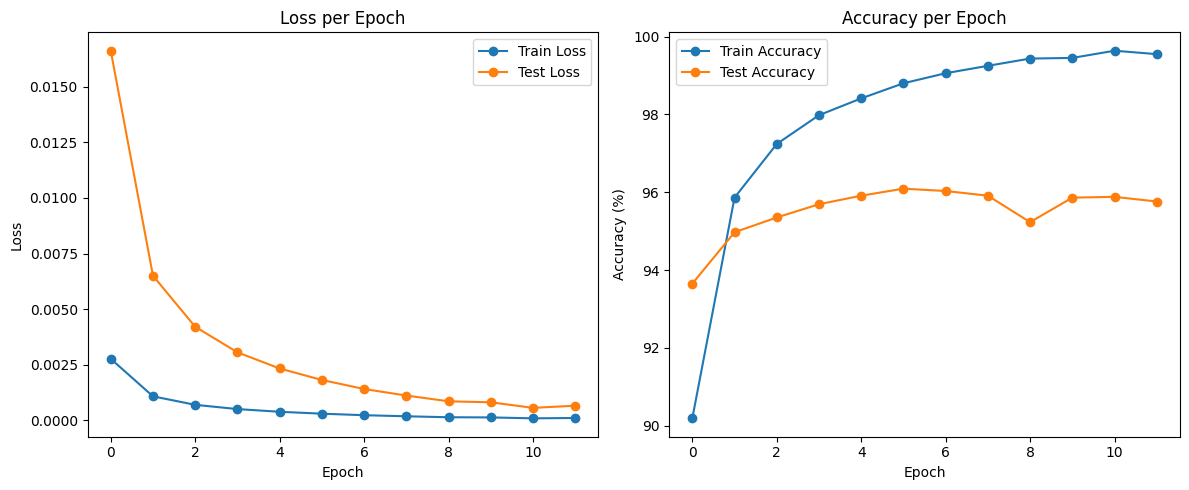

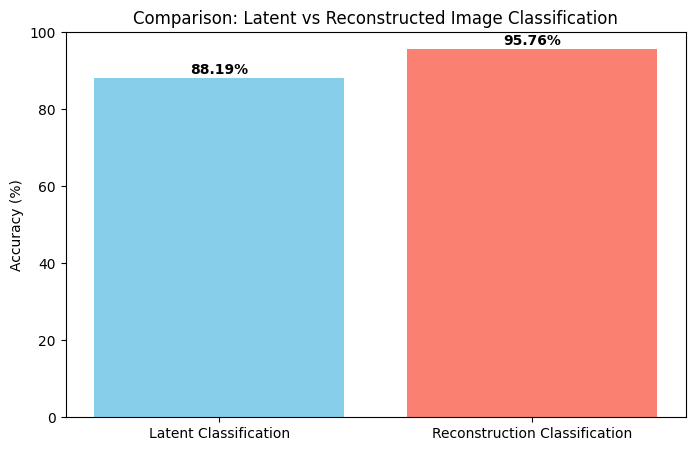

In [ ]:
# === INIT MODELS ===
vae_model = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
recon_clf = ReconClassifier().to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

# === TRAIN VAE ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 12

for epoch in range(epochs):
    vae_model.train()
    train_loss = 0
    correct, total = 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar, logits = vae_model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target)
        loss.backward()
        vae_optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    vae_model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, mu, logvar, logits = vae_model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

# === PLOT TRAINING VAE CURVE - LOSSES AND ACCURACIES ===
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# === VAE RECONSTRUCTIONS & BOTTLENECK CLASSIFIER PREDICTIONS ===
vae_model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    data = images[:8].view(-1, 784).to(device)
    recon, _, _, logits = vae_model(data)
    preds = logits.argmax(dim=1).cpu().numpy()
    images = images[:8].cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(12, 4))
    for i in range(8):
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Orig:{labels[i].item()}")
        plt.axis('off')
        plt.subplot(3, 8, i + 9)
        plt.imshow(recon[i][0], cmap='gray')
        plt.title(f"Btnk pred:{preds[i]}")
        plt.axis('off')
    plt.suptitle("Original (Top), Reconstructed (Bottom)")
    plt.tight_layout()
    plt.show()

# === TRAIN RECONSTRUCTION CLASSIFIER ON ORIGINAL IMAGES ===
clf_epochs = 12
clf_train_losses, clf_test_losses = [], []
clf_train_accuracies, clf_test_accuracies = [], []
for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    clf_train_losses.append(clf_loss / len(train_loader.dataset))
    clf_train_accuracies.append(100. * correct / total)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

    # === EVALUATE CLASSIFIER ON RECONSTRUCTED IMAGES ===
    recon_clf.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, _, _, _ = vae_model(data)
            logits = recon_clf(recon)
            loss = F.cross_entropy(logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    recon_acc = 100. * correct / total
    clf_test_losses.append(clf_loss / len(test_loader.dataset))
    clf_test_accuracies.append(100. * correct / total)
    print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

# === PLOT TRAINING CURVE FOR CLASSIFIER - LOSSES AND ACCURACIES ===
plot_training_curves(clf_train_losses, clf_test_losses, clf_train_accuracies, clf_test_accuracies)

# === PLOT COMPARISON ===
plt.figure(figsize=(8, 5))
plt.bar(['Latent Classification', 'Reconstruction Classification'], [test_accuracies[-1], recon_acc], color=['skyblue', 'salmon'])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Latent vs Reconstructed Image Classification")
plt.ylim(0, 100)
for i, v in enumerate([test_accuracies[-1], recon_acc]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

## t-SNE and Confusion matrix

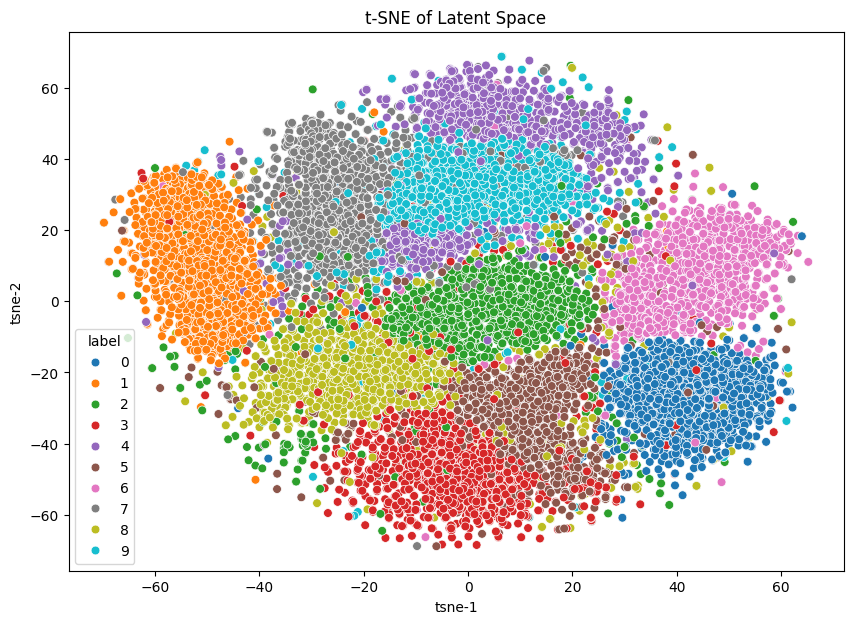

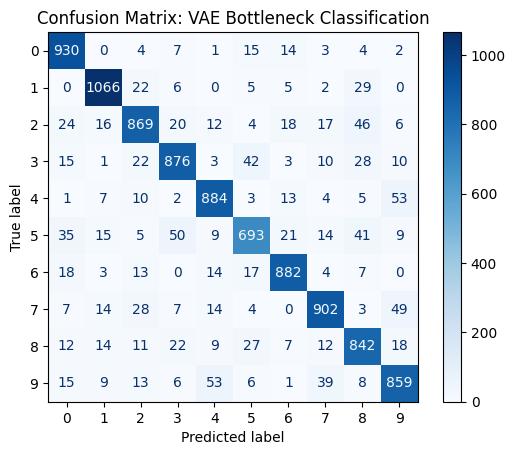

In [ ]:
# === t-SNE OF LATENT SPACE ===
zs, ys = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        mu, logvar = vae_model.encode(data)
        z = vae_model.reparameterize(mu, logvar)
        zs.append(z.cpu())
        ys.append(target)

zs = torch.cat(zs).numpy()
ys = torch.cat(ys).numpy()
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(zs)

df = pd.DataFrame({
    'tsne-1': z_2d[:, 0],
    'tsne-2': z_2d[:, 1],
    'label': ys
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tsne-1', y='tsne-2', hue='label', palette='tab10', s=40)
plt.title("t-SNE of Latent Space")
plt.show()